In [1]:
# hide
%reload_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import pandas as pd
import torch
import copy
from clientClass import *
from dataFunction import *
from HE_functions import *
import tenseal as ts
RANDOM_STATE = 123
%matplotlib inline
from time import time
torch.random.manual_seed(11007303)
random.seed(11007303)

In [23]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [7]:
n_clients = 4
n_features = 18
glob_model = LR(n_features)
EPOCHS = 80
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]

# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)

# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20

# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()


        

# Make Dataframes for every dataset

In [96]:

cleveland = "processed.cleveland.data"
switzerland = "processed.switzerland.data"
va = "processed.va.data"
hungarian = "reprocessed.hungarian.data"
cleveland_df, switzerland_df, va_df, hungarian_df = import_data(cleveland, switzerland, va, hungarian)
df_dict ={
    'Cleveland': cleveland_df,
    'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }



In [88]:
df_list = [cleveland_df,switzerland_df,va_df,hungarian_df]

In [73]:
possible_values = {}
possible_values['ST_Slope'] = cleveland_df['ST_Slope'].unique().astype(int)

In [76]:
list_of_possible_values = ['ST_Slope' + '_' + str(value) for value in possible_values['ST_Slope']]

In [81]:
pd.get_dummies(cleveland_df['ST_Slope'].astype(int), prefix = 'ST_Slope').T.reindex(list_of_possible_values).T.fillna(0)

,ST_Slope_3,ST_Slope_2,ST_Slope_1
0,1,0,0
1,0,1,0
2,0,1,0
3,1,0,0
4,0,0,1
...,...,...,...
298,0,1,0
299,0,1,0
300,0,1,0
301,0,1,0


In [77]:
pd.get_dummies(cleveland_df['ST_Slope'], prefix = 'ST_Slope').T.reindex(list_of_possible_values).T.fillna(0)

,ST_Slope_3,ST_Slope_2,ST_Slope_1
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
298,0.0,0.0,0.0
299,0.0,0.0,0.0
300,0.0,0.0,0.0
301,0.0,0.0,0.0


In [121]:
dfs = pd.concat(df_list)
dfs1 = new_df(dfs)
dfs2 = dfs1.drop(columns="HeartDisease")
numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Cholesterol', 'Oldpeak']
for j in numeric_feature_names:
    if dfs2[j].std() != 0: 
        dfs2[j] = (dfs2[j] - dfs2[j].mean()) / dfs2[j].std()
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
dfs3 = make_dummies(dfs2, cat_feat)

In [92]:
dfs.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000
mean,53.128472,0.777778,3.253472,132.275463,200.128472,0.135417,0.592593,137.545139,0.388889,0.877315,1.837963,0.547454
std,9.397538,0.415981,0.931917,18.468740,109.371462,0.342366,0.813126,25.921627,0.487780,1.087214,0.530981,0.498031
min,28.000000,0.000000,1.000000,80.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,0.000000
25%,46.000000,1.000000,3.000000,120.000000,177.750000,0.000000,0.000000,120.000000,0.000000,0.000000,2.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,224.000000,0.000000,0.000000,140.000000,0.000000,0.500000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,266.250000,0.000000,1.000000,157.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


In [97]:
clients = []
glob_model = LR(n_features)
for i in list(df_dict.keys()):
    df = df_dict.get(i)
    # df_dict[i] = new_df(df)
    location_data = new_df(df)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")
    cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
    location_data = make_dummies(location_data, cat_feat)
    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Cholesterol', 'Oldpeak']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    # print(ty pe(y))
    client_model = copy.deepcopy(glob_model)
    lr = 3
    lr_decay = 1
    clients.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss()))



In [64]:
import matplotlib.pyplot as plt

In [106]:
df = pd.concat([c.X for c in clients])

In [107]:
df.describe()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_1,ChestPainType_4,ChestPainType_3,ChestPainType_2,RestingECG_2,RestingECG_0,RestingECG_1,ST_Slope_3,ST_Slope_2,ST_Slope_1
count,8.640000e+02,864.000000,8.640000e+02,8.640000e+02,864.000000,8.640000e+02,864.000000,8.640000e+02,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.00000,864.000000
mean,4.882925e-17,0.777778,9.251859e-17,9.971448e-17,0.135417,-1.295260e-16,0.388889,1.233581e-17,0.048611,0.543981,0.214120,0.193287,0.209491,0.616898,0.173611,0.072917,0.69213,0.234954
std,9.982604e-01,0.415981,9.982604e-01,9.253730e-01,0.342366,9.982604e-01,0.487780,9.982604e-01,0.215178,0.498350,0.410448,0.395105,0.407181,0.486424,0.378994,0.260150,0.46188,0.424215
min,-2.832702e+00,0.000000,-2.312726e+00,-2.538857e+00,0.000000,-3.436382e+00,0.000000,-3.125549e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,-6.163070e-01,1.000000,-7.197781e-01,-5.416851e-01,0.000000,-6.903047e-01,0.000000,-6.465308e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,8.851022e-02,1.000000,-1.508680e-01,0.000000e+00,0.000000,3.984056e-02,0.000000,-3.786180e-01,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000
75%,7.258879e-01,1.000000,4.721790e-01,4.378157e-01,0.000000,6.932251e-01,1.000000,6.095547e-01,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000
max,2.496061e+00,1.000000,3.881319e+00,6.128347e+00,1.000000,2.591342e+00,1.000000,4.850669e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [122]:
dfs3.describe()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_1,ChestPainType_4,ChestPainType_3,ChestPainType_2,RestingECG_2,RestingECG_0,RestingECG_1,ST_Slope_3,ST_Slope_2,ST_Slope_1
count,8.640000e+02,864.000000,8.640000e+02,8.640000e+02,864.000000,8.640000e+02,864.000000,8.640000e+02,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.00000,864.000000
mean,1.151342e-16,0.777778,6.167906e-17,-9.868649e-17,0.135417,1.151342e-16,0.388889,4.111937e-17,0.048611,0.543981,0.214120,0.193287,0.209491,0.616898,0.173611,0.072917,0.69213,0.234954
std,1.000000e+00,0.415981,1.000000e+00,1.000000e+00,0.342366,1.000000e+00,0.487780,1.000000e+00,0.215178,0.498350,0.410448,0.395105,0.407181,0.486424,0.378994,0.260150,0.46188,0.424215
min,-2.673942e+00,0.000000,-2.830483e+00,-1.829805e+00,0.000000,-2.991523e+00,0.000000,-3.198372e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,-7.585468e-01,1.000000,-6.646616e-01,-2.046098e-01,0.000000,-6.768533e-01,0.000000,-8.069386e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,9.274001e-02,1.000000,-1.232062e-01,2.182610e-01,0.000000,9.470320e-02,0.000000,-3.470475e-01,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000
75%,7.312051e-01,1.000000,4.182493e-01,6.045592e-01,0.000000,7.505262e-01,1.000000,5.727348e-01,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000
max,2.540190e+00,1.000000,3.666982e+00,3.683516e+00,1.000000,2.486528e+00,1.000000,4.895711e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


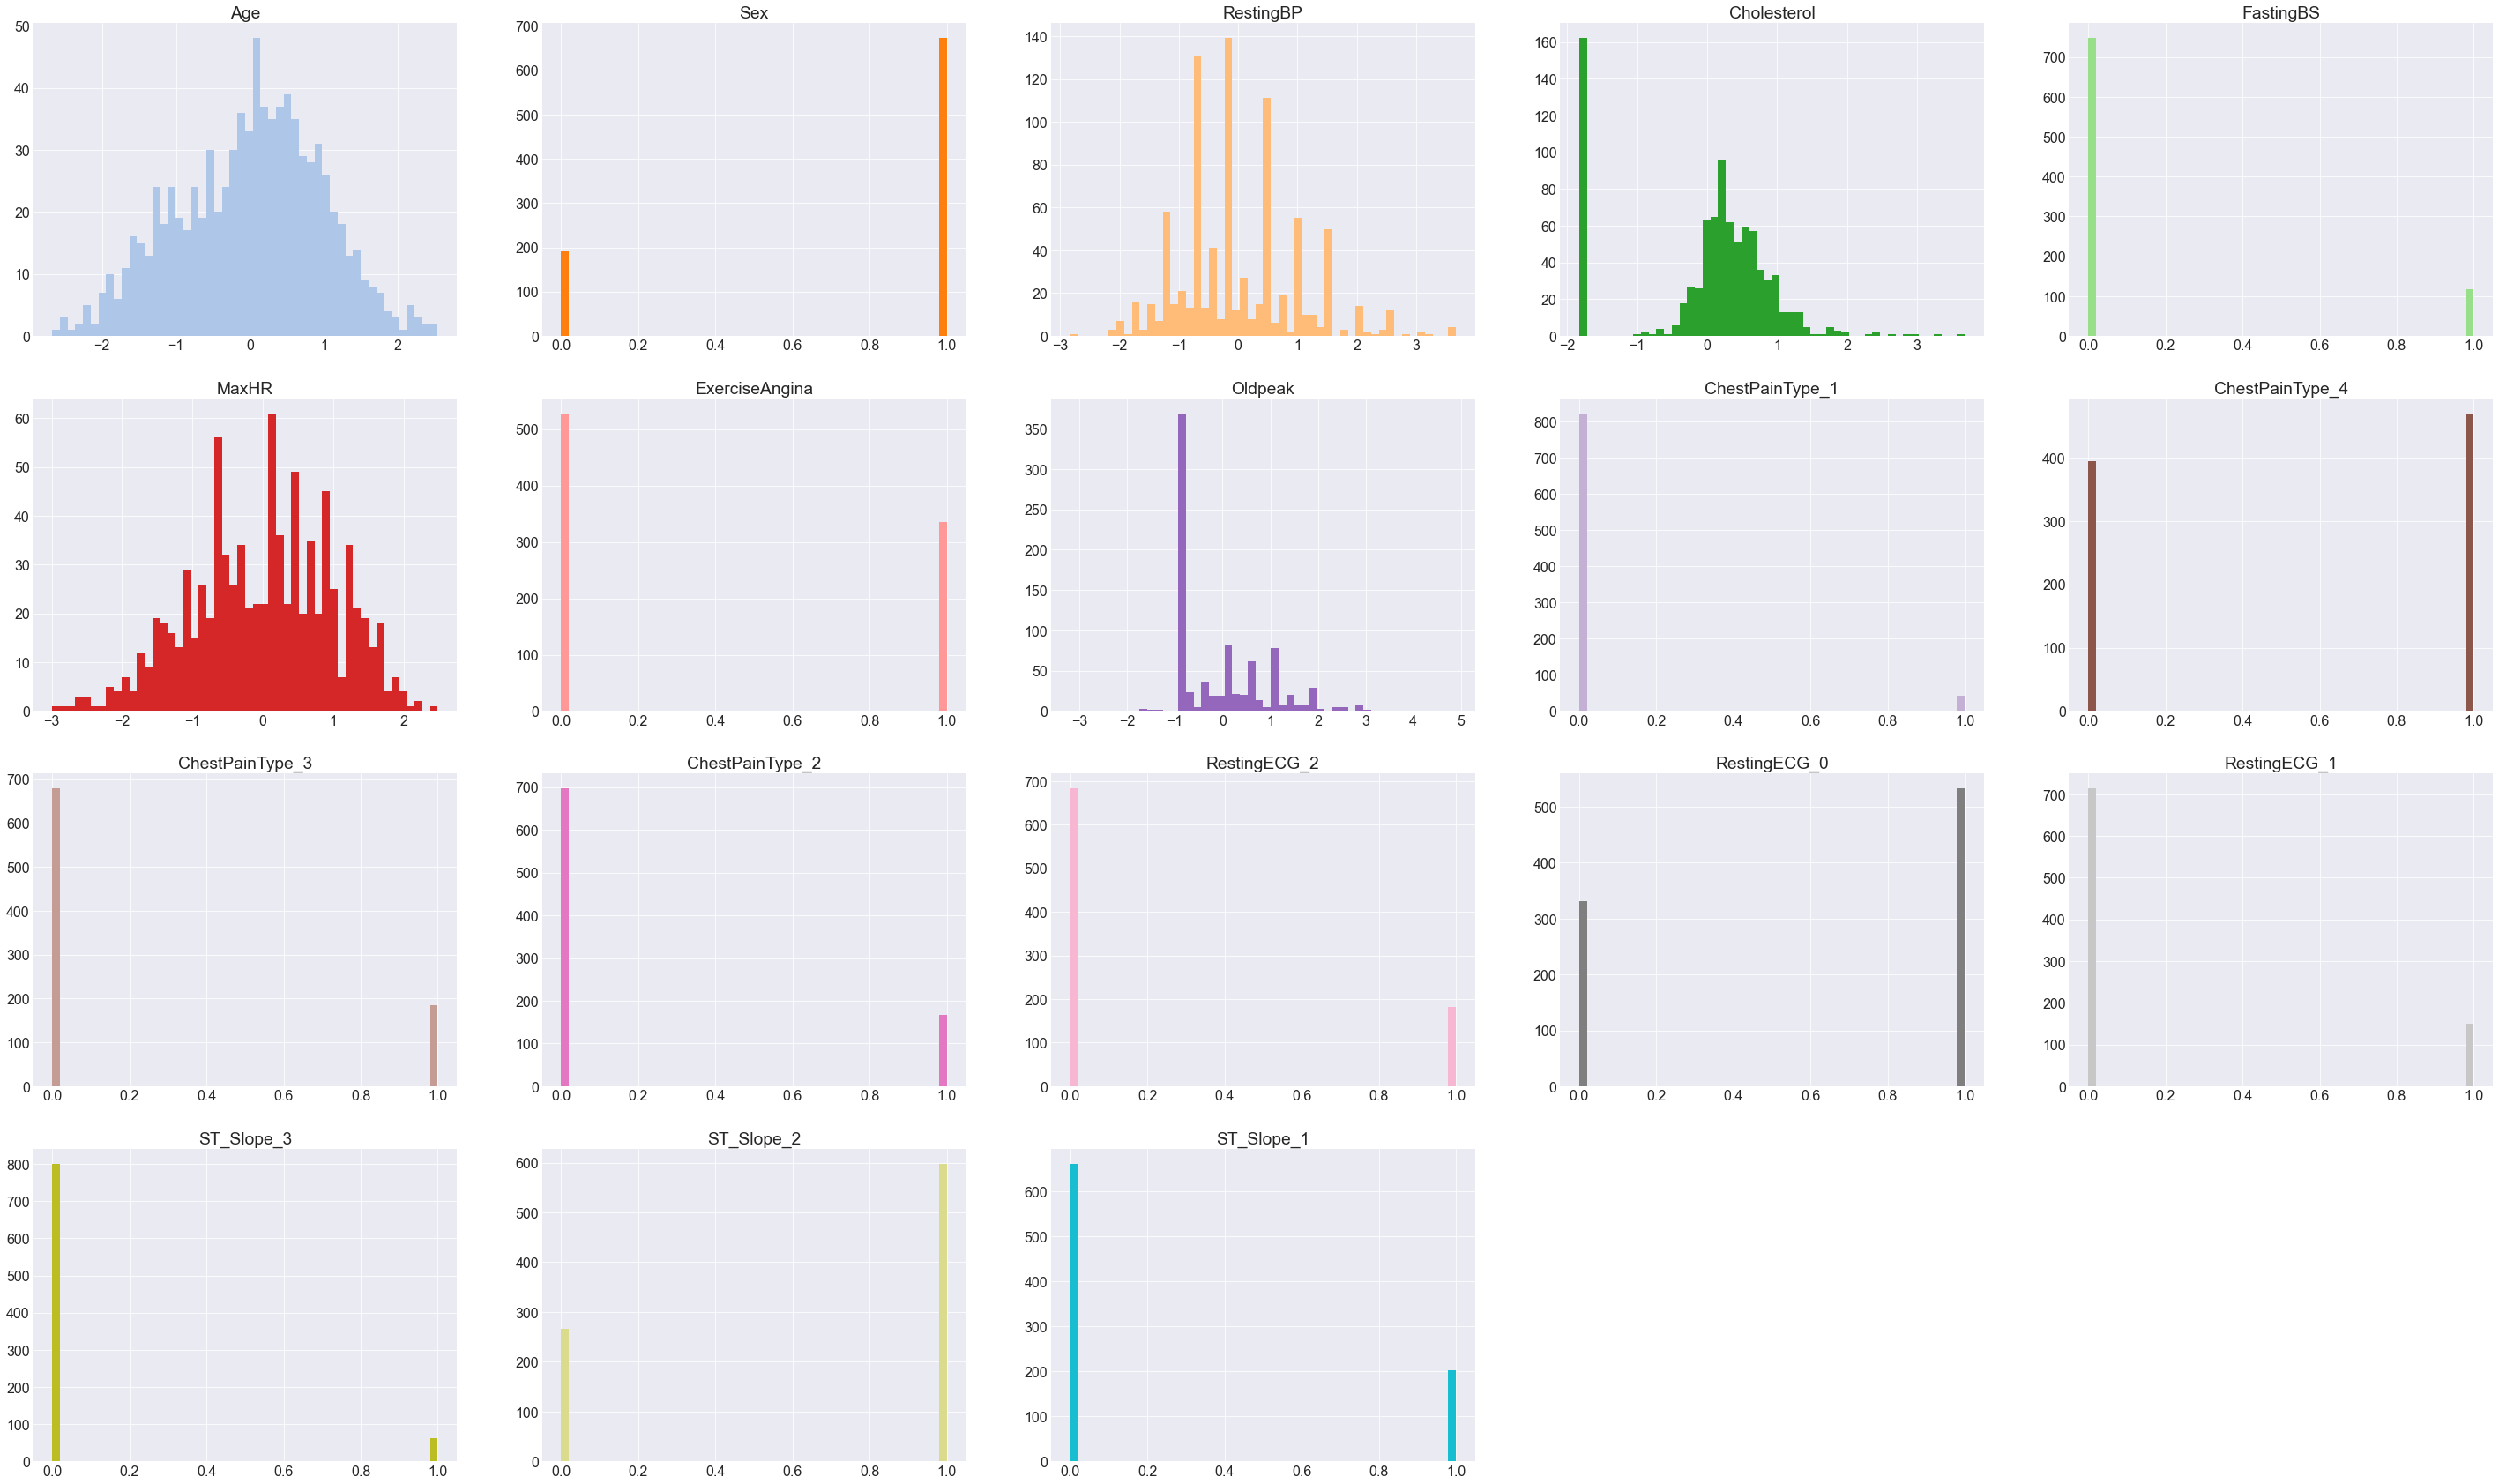

In [123]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('tab20')
plt.rcParams.update({'font.size': 16,})
num=1
f= plt.figure(figsize=(50,30))
for var in list(dfs3.columns.array):
    ax = f.add_subplot(4,5,num)
    a = np.asarray(dfs3[var].dropna())
    ax.hist(a, bins=50, color=palette(num))
    ax.set_title(var)
    num+=1
# f.savefig('distribution_data_combined.png')

In [23]:
validation_X_set = torch.tensor(())
validation_y_set = torch.tensor(())
for i in range(len(clients)):
    validation_X_set = torch.cat((validation_X_set, clients[i].X_test), 0)
    validation_y_set = torch.cat((validation_y_set, clients[i].y_test), 0)


In [24]:
validation_y_set = validation_y_set.unsqueeze(1)

In [12]:
import numpy as np

In [13]:
np.random.default_rng().normal(3, scale=0.1, size=(2, 10))

array([[2.96305019, 2.93344056, 3.04856015, 3.02015159, 3.04170178,
        2.90429699, 2.93655102, 2.86044691, 2.915007  , 2.77595599],
       [2.9491362 , 3.06783419, 2.7820405 , 3.07765248, 3.01584585,
        3.17789999, 2.91470422, 3.08716752, 2.96857453, 2.94770245]])

In [26]:
best_epoch, best_acc, model_dict, final_results = FL_proces(clients, validation_X_set,validation_y_set, ctx_eval, glob_model, iters= 100)

In [14]:
loss_train = []
net_best = None
best_acc = None
best_epoch = None
results = []
min_loss_client = []
glob_model = LR(n_features)
glob_model.eval()
for iter in range(50):
    loss_locals = []
    client_state_dicts = []
    for client in clients:
        client.set_state_dict(glob_model.state_dict())
        client_state_dict, loss = client.train()
        
        loss_locals.append(copy.deepcopy(loss))
        min_loss_client.append(min(loss))
        client_state_dicts.append(client_state_dict)

    enrypted_state_dicts = encrypt_state_dicts(copy.deepcopy(client_state_dicts), ctx_eval)
    averaged_encrypted_state_dict = average_state_dict(enrypted_state_dicts)
    decrypted_state_dicts = decrypt_state_dicts(averaged_encrypted_state_dict)
    glob_model.load_state_dict(decrypted_state_dicts)

    loss_avg = sum(min_loss_client) / len(min_loss_client)
    loss_train.append(loss_avg)        
        
    acc_test, loss_test =  accuracy_loss_LR(glob_model,validation_X_set, validation_y_set)

    print('Round {:3d}, Average loss {:.3f}, Test loss {:.3f}, Test accuracy: {:.2f}'.format(
        iter, loss_avg, loss_test, acc_test))


    if best_acc is None or acc_test > best_acc:
        net_best = copy.deepcopy(glob_model)
        best_acc = acc_test
        best_epoch = iter

    results.append(np.array([iter, loss_avg, loss_test, acc_test, best_acc]))
    final_results = np.array(results)
    final_results = pd.DataFrame(final_results, columns=['epoch', 'loss_avg', 'loss_test', 'acc_test', 'best_acc'])

print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))    
    

AttributeError: 'Client' object has no attribute 'train'

In [3]:
sum([1.15417093, 1.4052553,  0.22369934, 0.00816102, 0.61252271, 0.92022354,
 0.17126086, 1.29912417, 0.15427603, 0.0513061 ])

6.0